In [1]:
# Custom Imports
import polysaccharide as ps
from polysaccharide import analysis, extratypes, filetree, general, logutils, molutils
from polysaccharide import polymer

from polysaccharide.charging.residues import ChargedResidue
from polysaccharide.charging.application import CHARGER_REGISTRY, ChargingParameters

from polysaccharide import LOGGERS_MASTER
from polysaccharide.logutils import ProcessLogHandler

from polysaccharide.molutils.rdmol import rdkdraw, rdprops, rdcompare, rdconvert

from polysaccharide.polymer.representation import Polymer
from polysaccharide.polymer.management import PolymerManager
from polysaccharide.polymer.filtering import has_sims, is_solvated, is_unsolvated, is_charged
from polysaccharide.polymer import building, monomer

from polysaccharide.solvation.solvents import WATER_TIP3P
from polysaccharide.analysis import trajectory, statistics
from polysaccharide.simulation.records import SimulationPaths, SimulationParameters
from polysaccharide.graphics import plotutils

# Generic Imports
import re
from functools import partial
from collections import defaultdict
from itertools import combinations

# Numeric imports
from math import ceil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Typing and Subclassing
from typing import Any, Callable, ClassVar, Iterable, Optional, Union
from dataclasses import dataclass, field
from abc import ABC, abstractmethod, abstractproperty, abstractstaticmethod
from openmm.unit import Unit, Quantity

# File I/O
import argparse
from pathlib import Path
import csv, json, pickle
from shutil import copyfile, rmtree
import importlib.resources as impres

# Logging and Shell
import logging
logging.basicConfig(
    level=logging.INFO,
    format=logutils.LOG_FORMATTER._fmt,
    datefmt=logutils.LOG_FORMATTER.datefmt,
    force=True
)
                            
# Cheminformatics
from rdkit import Chem
from rdkit.Chem import rdmolfiles

# Molecular Dynamics
from openff.interchange import Interchange
from openff.toolkit import ForceField
from openff.toolkit.topology import Topology
from openff.toolkit.topology.molecule import Molecule, Atom
from openff.toolkit.typing.engines.smirnoff.parameters import LibraryChargeHandler

from openff.units import unit
from openmm.unit import picosecond, femtosecond, nanosecond # time
from openmm.unit import nanometer, angstrom # length
from openmm.unit import kelvin, atmosphere # misc

# polymer resource management
import importlib_resources as impres
from polysaccharide import resources
from polysaccharide.resources import AVAIL_RESOURCES

RESOURCE_PATH = resources.RESOURCE_PATH
SIM_PARAM_PATH = impres.files(resources.sim_templates)
CHG_PARAM_PATH = impres.files(resources.chg_templates)
INP_PARAM_PATH = impres.files(resources.inp_templates)

/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
Wa

## Defining Paths and PolymerManagers

In [2]:
# Data file directories
affix = '_v4'
data_dir = Path(f'data{affix}')
data_dir.mkdir(exist_ok=True)

colina_dir   = data_dir / 'colina_data'
openff_dir   = data_dir / 'openff_data'
combined_dir = data_dir / 'combined_data'

for super_dir in (openff_dir, combined_dir, colina_dir):
    super_dir.mkdir(exist_ok=True)
    for subdir_name in ('rdfs', 'props'):
        subdir = super_dir / subdir_name
        subdir.mkdir(exist_ok=True)
        globals()[f'{super_dir.name}_{subdir_name}'] = subdir # assign to variables in namespace

# Plot directories
fig_dir  = Path(f'figures{affix}')
fig_dir.mkdir(exist_ok=True)

plot_prop_dir = fig_dir / 'property_plots'
plot_prop_dir.mkdir(exist_ok=True)

plot_rdf_dir = fig_dir / 'rdf_plots'
plot_rdf_dir.mkdir(exist_ok=True)

# Polymer collections
COLL_PATH = Path('Reruns_PBC_2')

src_mgr   = PolymerManager(COLL_PATH / 'water_soluble_polymers')
redux_mgr = PolymerManager(COLL_PATH / 'water_soluble_reduced')
conf_mgr  = PolymerManager(COLL_PATH / 'water_soluble_polymers_confs')
equil_mgr = PolymerManager(COLL_PATH / 'water_soluble_polymers_equil')

## Measuring sizes of reduced and full-size chains

In [ ]:
size_dir = data_dir / 'chain_sizes'
size_dir.mkdir(exist_ok=True)

# Producing atom and monomer number counts
for targ_mgr in (redux_mgr, src_mgr):
    size_dict = {}
    for mol_name, polymer in targ_mgr.polymers.items():
        SMARTS = polymer.monomer_info.SMARTS
        DOP = monomer.estimate_DOP_upper(SMARTS, min_chain_len=polymer.n_atoms)
        N = monomer.estimate_chain_len(SMARTS, DOP=DOP)
        assert(N == polymer.n_atoms)

        size_dict[mol_name] = {
            'N_atoms' : N,
            'N_monomers' : DOP
        }
    size_table = pd.DataFrame.from_dict(size_dict, orient='index')
    size_table.to_csv(size_dir / f'{targ_mgr.collection_dir.name}_sizes.csv') # index deliberately left in

# Collating shape property data from simulation and Colina paper

## Analyzing trajectories and saving analyzed results to CSVs to avoid recomputing

In [4]:
for mol_name, sim_dirs_list in equil_mgr.all_completed_sims.items():
    polymer = equil_mgr.polymers[mol_name]
    for sim_dir in sim_dirs_list:
        print(mol_name, ' : ', sim_dir.name)
        sim_paths, sim_params = polymer.load_sim_paths_and_params(sim_dir)

        # loading and assessing trajectories
        traj = polymer.load_traj(sim_dir)
        traj_no_solv = traj.remove_solvent(inplace=False)
        unique_elems = set(atom.element.symbol for atom in traj.topology.atoms)

        # defining atom pairs
        pair_dict = {
            'chain O - water O' : traj.top.select_pairs('not water and element O', 'water and element O'),
            'water O - water O' : traj.top.select_pairs('water and element O', 'water and element O')
        }
        
        if 'N' in unique_elems:
            pair_dict['chain N - water O'] = traj.top.select_pairs('not water and element N', 'water and element O')

        # computing and saving shape property time series'
        sim_paths.time_data = sim_dir / f'{mol_name}_time_series.csv'
        prop_data = trajectory.acquire_time_props(traj_no_solv, time_points=sim_params.time_points) 
        prop_data.to_csv(sim_paths.time_data, index=False)

        # computing and saving RDFs 
        sim_paths.spatial_data = sim_dir / f'{mol_name}_rdfs.csv'
        rdf_data = trajectory.acquire_rdfs(traj[:2], pair_dict, min_rad=0.0, max_rad=2.0, rad_unit=nanometer)
        rdf_data.to_csv(sim_paths.spatial_data, index=False) # overwrite rdfs with correct raii ranges

        # updating path references
        sim_paths.to_file(polymer.simulation_paths[sim_dir])

paam_modified_conf_4_solv_water_equil_solv_water  :  100_ns_NVT_ABE10_avgd_08-30-2023_at_16-51-30_PM


/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning: WARNING: two consecutive residues with same number (HETATM  423  H1  HOH A   1       8.199  23.228  34.238  1.00  0.00              , ATOM    422  H   RES A   1      27.529  30.560  19.136  1.00  0.00           H  )
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (atom, self._current_residue.atoms[-1]))


paam_modified_conf_4_solv_water_equil_solv_water  :  100_ns_NVT_espaloma_08-30-2023_at_20-37-51_PM


/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning: WARNING: two consecutive residues with same number (HETATM  423  H1  HOH A   1       8.199  23.228  34.238  1.00  0.00              , ATOM    422  H   RES A   1      27.529  30.560  19.136  1.00  0.00           H  )
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (atom, self._current_residue.atoms[-1]))


paam_modified_conf_2_solv_water_equil_solv_water  :  100_ns_NVT_espaloma_08-30-2023_at_20-38-29_PM


/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning: WARNING: two consecutive residues with same number (HETATM  423  H1  HOH A   1      18.265  40.322  19.356  1.00  0.00              , ATOM    422  H   RES A   1      16.789  21.184  27.442  1.00  0.00           H  )
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (atom, self._current_residue.atoms[-1]))


paam_modified_conf_2_solv_water_equil_solv_water  :  100_ns_NVT_ABE10_avgd_08-30-2023_at_16-51-31_PM


/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning: WARNING: two consecutive residues with same number (HETATM  423  H1  HOH A   1      18.265  40.322  19.356  1.00  0.00              , ATOM    422  H   RES A   1      16.789  21.184  27.442  1.00  0.00           H  )
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (atom, self._current_residue.atoms[-1]))


paam_modified_conf_1_solv_water_equil_solv_water  :  100_ns_NVT_ABE10_avgd_08-30-2023_at_16-52-08_PM


/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning: WARNING: two consecutive residues with same number (HETATM  423  H1  HOH A   1      29.670  39.154   0.322  1.00  0.00              , ATOM    422  H   RES A   1      24.019  31.620  27.853  1.00  0.00           H  )
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (atom, self._current_residue.atoms[-1]))


paam_modified_conf_1_solv_water_equil_solv_water  :  100_ns_NVT_espaloma_08-30-2023_at_20-38-40_PM


/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning: WARNING: two consecutive residues with same number (HETATM  423  H1  HOH A   1      29.670  39.154   0.322  1.00  0.00              , ATOM    422  H   RES A   1      24.019  31.620  27.853  1.00  0.00           H  )
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (atom, self._current_residue.atoms[-1]))


paam_modified_conf_3_solv_water_equil_solv_water  :  100_ns_NVT_ABE10_avgd_08-30-2023_at_16-51-27_PM


/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning: WARNING: two consecutive residues with same number (HETATM  423  H1  HOH A   1       5.928  45.093   8.145  1.00  0.00              , ATOM    422  H   RES A   1      21.813  35.975  17.559  1.00  0.00           H  )
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (atom, self._current_residue.atoms[-1]))


paam_modified_conf_3_solv_water_equil_solv_water  :  100_ns_NVT_espaloma_08-30-2023_at_20-35-30_PM


/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning: WARNING: two consecutive residues with same number (HETATM  423  H1  HOH A   1       5.928  45.093   8.145  1.00  0.00              , ATOM    422  H   RES A   1      21.813  35.975  17.559  1.00  0.00           H  )
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (atom, self._current_residue.atoms[-1]))


pnipam_modified_conf_1_solv_water_equil_solv_water  :  100_ns_NVT_ABE10_avgd_08-30-2023_at_16-53-10_PM


/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning: WARNING: two consecutive residues with same number (HETATM  516  H1  HOH A   1      39.735  14.399   8.965  1.00  0.00              , ATOM    515  H   RES A   1      29.543  17.819  17.194  1.00  0.00           H  )
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (atom, self._current_residue.atoms[-1]))


pnipam_modified_conf_1_solv_water_equil_solv_water  :  100_ns_NVT_espaloma_08-30-2023_at_21-05-47_PM


/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning: WARNING: two consecutive residues with same number (HETATM  516  H1  HOH A   1      39.735  14.399   8.965  1.00  0.00              , ATOM    515  H   RES A   1      29.543  17.819  17.194  1.00  0.00           H  )
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (atom, self._current_residue.atoms[-1]))


pnipam_modified_conf_4_solv_water_equil_solv_water  :  100_ns_NVT_espaloma_08-30-2023_at_20-52-17_PM


/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning: WARNING: two consecutive residues with same number (HETATM  516  H1  HOH A   1       9.213  41.680   4.263  1.00  0.00              , ATOM    515  H   RES A   1      28.800  18.553  23.451  1.00  0.00           H  )
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (atom, self._current_residue.atoms[-1]))


pnipam_modified_conf_4_solv_water_equil_solv_water  :  100_ns_NVT_ABE10_avgd_08-30-2023_at_16-52-17_PM


/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning: WARNING: two consecutive residues with same number (HETATM  516  H1  HOH A   1       9.213  41.680   4.263  1.00  0.00              , ATOM    515  H   RES A   1      28.800  18.553  23.451  1.00  0.00           H  )
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (atom, self._current_residue.atoms[-1]))


pnipam_modified_conf_2_solv_water_equil_solv_water  :  100_ns_NVT_ABE10_avgd_08-30-2023_at_16-52-21_PM


/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning: WARNING: two consecutive residues with same number (HETATM  516  H1  HOH A   1      47.325  39.003  45.371  1.00  0.00              , ATOM    515  H   RES A   1      38.455  21.669  28.093  1.00  0.00           H  )
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (atom, self._current_residue.atoms[-1]))


pnipam_modified_conf_2_solv_water_equil_solv_water  :  100_ns_NVT_espaloma_08-30-2023_at_20-48-26_PM


/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning: WARNING: two consecutive residues with same number (HETATM  516  H1  HOH A   1      47.325  39.003  45.371  1.00  0.00              , ATOM    515  H   RES A   1      38.455  21.669  28.093  1.00  0.00           H  )
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (atom, self._current_residue.atoms[-1]))


pnipam_modified_conf_3_solv_water_equil_solv_water  :  100_ns_NVT_ABE10_avgd_08-30-2023_at_16-52-15_PM


/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning: WARNING: two consecutive residues with same number (HETATM  516  H1  HOH A   1       7.216  37.311  49.357  1.00  0.00              , ATOM    515  H   RES A   1      25.226  20.898  36.129  1.00  0.00           H  )
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (atom, self._current_residue.atoms[-1]))


pnipam_modified_conf_3_solv_water_equil_solv_water  :  100_ns_NVT_espaloma_08-30-2023_at_20-40-13_PM


/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning: WARNING: two consecutive residues with same number (HETATM  516  H1  HOH A   1       7.216  37.311  49.357  1.00  0.00              , ATOM    515  H   RES A   1      25.226  20.898  36.129  1.00  0.00           H  )
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (atom, self._current_residue.atoms[-1]))


peg_modified_conf_1_solv_water_equil_solv_water  :  100_ns_NVT_espaloma_08-30-2023_at_21-10-04_PM


/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning: WARNING: two consecutive residues with same number (HETATM  262  H1  HOH A   1      28.534  26.450  10.637  1.00  0.00              , ATOM    261  H   RES A   1      19.409  14.432  32.454  1.00  0.00           H  )
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (atom, self._current_residue.atoms[-1]))


peg_modified_conf_1_solv_water_equil_solv_water  :  100_ns_NVT_ABE10_avgd_08-30-2023_at_16-52-59_PM


/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning: WARNING: two consecutive residues with same number (HETATM  262  H1  HOH A   1      28.534  26.450  10.637  1.00  0.00              , ATOM    261  H   RES A   1      19.409  14.432  32.454  1.00  0.00           H  )
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (atom, self._current_residue.atoms[-1]))


peg_modified_conf_2_solv_water_equil_solv_water  :  100_ns_NVT_espaloma_08-30-2023_at_21-19-17_PM


/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning: WARNING: two consecutive residues with same number (HETATM  262  H1  HOH A   1      29.583   9.839  24.086  1.00  0.00              , ATOM    261  H   RES A   1      20.704  27.685  23.801  1.00  0.00           H  )
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (atom, self._current_residue.atoms[-1]))


peg_modified_conf_2_solv_water_equil_solv_water  :  100_ns_NVT_ABE10_avgd_08-30-2023_at_16-53-05_PM


/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning: WARNING: two consecutive residues with same number (HETATM  262  H1  HOH A   1      29.583   9.839  24.086  1.00  0.00              , ATOM    261  H   RES A   1      20.704  27.685  23.801  1.00  0.00           H  )
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (atom, self._current_residue.atoms[-1]))


peg_modified_conf_4_solv_water_equil_solv_water  :  100_ns_NVT_ABE10_avgd_08-30-2023_at_16-51-47_PM


/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning: WARNING: two consecutive residues with same number (HETATM  262  H1  HOH A   1       8.101  48.987   7.282  1.00  0.00              , ATOM    261  H   RES A   1      23.745  32.079  30.660  1.00  0.00           H  )
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (atom, self._current_residue.atoms[-1]))


peg_modified_conf_4_solv_water_equil_solv_water  :  100_ns_NVT_espaloma_08-30-2023_at_21-34-32_PM


/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning: WARNING: two consecutive residues with same number (HETATM  262  H1  HOH A   1       8.101  48.987   7.282  1.00  0.00              , ATOM    261  H   RES A   1      23.745  32.079  30.660  1.00  0.00           H  )
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (atom, self._current_residue.atoms[-1]))


peg_modified_conf_3_solv_water_equil_solv_water  :  100_ns_NVT_ABE10_avgd_08-30-2023_at_16-53-00_PM


/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning: WARNING: two consecutive residues with same number (HETATM  262  H1  HOH A   1      15.110  26.037   9.379  1.00  0.00              , ATOM    261  H   RES A   1      14.343  23.267  19.503  1.00  0.00           H  )
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (atom, self._current_residue.atoms[-1]))


peg_modified_conf_3_solv_water_equil_solv_water  :  100_ns_NVT_espaloma_08-30-2023_at_21-12-07_PM


/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning: WARNING: two consecutive residues with same number (HETATM  262  H1  HOH A   1      15.110  26.037   9.379  1.00  0.00              , ATOM    261  H   RES A   1      14.343  23.267  19.503  1.00  0.00           H  )
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (atom, self._current_residue.atoms[-1]))


## Extracting high-dimensional data "cube" of observable averages for all replicates

In [5]:
full_prop_data = defaultdict(lambda : defaultdict(lambda : defaultdict(list)))
full_rdf_data  = defaultdict(lambda : defaultdict(lambda : defaultdict(pd.DataFrame)))

for mol_name, sim_dirs_list in equil_mgr.all_completed_sims.items():
    polymer = equil_mgr.polymers[mol_name]
    conf_id = re.search(r'(?<=conf_)(\d+)', mol_name) # conformer number of the molecule in question
    if conf_id is not None:
        conf_id = int(conf_id.group())

    for sim_dir in sim_dirs_list:
        sim_paths, sim_params = polymer.load_sim_paths_and_params(sim_dir)

        # collating shape properties
        time_data = pd.read_csv(sim_paths.time_data)
        time_steps, time_samples = trajectory.props_to_plot_data(time_data)
        for prop_name, time_series in time_samples.items():
            full_prop_data[polymer.base_mol_name][sim_params.charge_method][prop_name].append(time_series.mean())

        # collating radial distribution functions
        rdf_data = pd.read_csv(sim_paths.spatial_data)
        radii_openff, rdfs = trajectory.rdfs_to_plot_data(rdf_data)

        for atom_pair_name, rdf in rdfs.items():
            full_rdf_data[polymer.base_mol_name][sim_params.charge_method][atom_pair_name][f'Conformer {conf_id}'] = rdf

## Computing means and uncertainties for shape props, saving to unified dataframes


In [6]:
dframe_fns = {
    'observables'   : np.mean,
    'uncertainties' : np.std
}

In [ ]:
for mol_name, mol_dict in full_prop_data.items():
    dframe = pd.DataFrame.from_dict({
        f'Sage 2.0.0 - {chg_method}' : {
            (stat_name, prop_name) : stat_fn(prop_data)
                for stat_name, stat_fn in dframe_fns.items()
                    for prop_name, prop_data in data_dict.items()
        }
        for chg_method, data_dict in mol_dict.items()
    })
    dframe.to_csv(openff_data_props / f'{mol_name}.csv') # index deliberately left in

### Merging property dataframes with data from Colina paper

In [ ]:
for ref_data_dir in colina_data_props.iterdir():
    filename = ref_data_dir.name

    new_data = pd.read_csv(openff_data_props / filename, index_col=[0, 1])
    ref_data = pd.read_csv(ref_data_dir         , index_col=[0, 1])
    data = pd.concat([new_data, ref_data], axis=1)

    data.to_csv(combined_data_props / filename)

## Computing means and uncertainty series' for RDFs, saving to unified dataframes

In [7]:
for mol_name, mol_dict in full_rdf_data.items():
    df_dict = defaultdict(defaultdict)

    for chg_method, data_dict in mol_dict.items():
        for elem_pair, rdf_data in data_dict.items():
            framework = f'Sage 2.0.0 - {chg_method}'
            df_dict[framework][(elem_pair, radii_openff.columns[0])] = radii_openff['Radius (nanometer)'].to_list()
            for stat_name, stat_fn in dframe_fns.items():
                df_dict[framework][(elem_pair, stat_name)] = list(stat_fn(rdf_data.to_numpy(), axis=1))

    dframe = pd.DataFrame.from_dict(df_dict)
    dframe.to_csv(openff_data_rdfs / f'{mol_name}.csv') # index deliberately left in

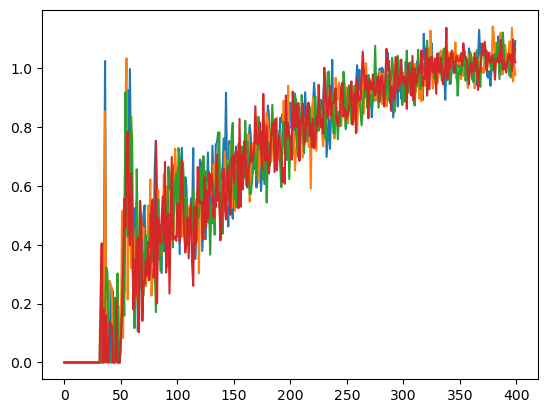

In [23]:
plt.plot(full_rdf_data['paam_modified']['ABE10_averaged']['g(r) (chain O - water O)'])

In [20]:
full_rdf_data

defaultdict(<function __main__.<lambda>()>,
            {'paam_modified': defaultdict(<function __main__.<lambda>.<locals>.<lambda>()>,
                         {'ABE10_averaged': defaultdict(pandas.core.frame.DataFrame,
                                      {'g(r) (chain O - water O)':      Conformer 4  Conformer 2  Conformer 1  Conformer 3
                                       0       0.000000     0.000000     0.000000     0.000000
                                       1       0.000000     0.000000     0.000000     0.000000
                                       2       0.000000     0.000000     0.000000     0.000000
                                       3       0.000000     0.000000     0.000000     0.000000
                                       4       0.000000     0.000000     0.000000     0.000000
                                       ..           ...          ...          ...          ...
                                       395     1.007506     0.966642     0.971259     

### Collating manually-extracted RDF data into plotting-compatible CSVs

In [8]:
CSV_NAME_SPLIT = re.compile(r'(\w+)\s(\w)-(\w)\Z')
col_renames = {
    'DD' : 'DREIDING - RESP',
    'tip3p' : 'CHARMM - Mulliken',
    'tip3pc' : 'CHARMM-c - Mulliken',
    'GAFF' : 'GAFF - RESP',
    'GAFF2' : 'GAFF2 - RESP',
    'r' : 'Radius (nanometer)'
}

rdfs = defaultdict(defaultdict)
manual_csv_dir = colina_data_rdfs / 'manually_split_csvs'

for path in manual_csv_dir.iterdir():
    if path.suffix == '.csv':
        mol_name, chain_elem, water_elem = re.search(CSV_NAME_SPLIT, path.stem).groups()
        colina_df = pd.read_csv(path)
        colina_df['r'] = colina_df['r'].apply(lambda x : x / 10.0) # convert readii to nanometers from angstroms
        colina_df.rename(col_renames, axis=1, inplace=True)      # adjust names to match property plots

        rdfs[mol_name][f'g(r) (chain {chain_elem} - water {water_elem})'] = colina_df

In [9]:
mol_rename = {
    'PEG' : 'peg_modified',
    'PAAm' : 'paam_modified',
    'PNIPAAm' : 'pnipam_modified'
}

for mol_name, rdf_dict in rdfs.items():
    mol_rdf_dict = defaultdict(defaultdict)
    for elem_pair, rdf_dframe in rdf_dict.items():
        radii_colina, rdf_only_df = trajectory.rdfs_to_plot_data(rdf_dframe)
        for framework, rdf_series in rdf_only_df.items():
            rdf_list = rdf_series.to_list()
            mol_rdf_dict[framework][(elem_pair, radii_colina.columns[0])] = radii_colina['Radius (nanometer)'].to_list()
            mol_rdf_dict[framework][(elem_pair, 'observables'  )] = rdf_list
            mol_rdf_dict[framework][(elem_pair, 'uncertainties')] = [0.0 for _  in rdf_list]# set uncertainties to 0 (since no replicates are available)
    
    fmt_dframe = pd.DataFrame.from_dict(mol_rdf_dict)
    fmt_dframe.to_csv(colina_data_rdfs / f'{mol_rename[mol_name]}.csv')        

### Merging property dataframes with data from Colina paper

In [10]:
for path in openff_data_rdfs.iterdir():
    filename = path.name
    openff_rdfs = pd.read_csv(path, index_col=(0, 1))
    colina_rdfs = pd.read_csv(colina_data_rdfs / filename, index_col=(0, 1))

    combined_rdfs = pd.concat([openff_rdfs, colina_rdfs], axis=1)
    combined_rdfs.to_csv(combined_data_rdfs / filename)

# Plotting shape props and RDFs

## Shape Properties

In [11]:
# defining colors for MD framework (sampled from tab20)
color_set = (
    'blue',
    'orange',
    'green',
    'purple',
    'grey',
)
hues_per_color = 4
cmap = plt.get_cmap('tab20c')

cdict, carr = plotutils.label_discrete_cmap(cmap, color_set, hues_per_color)
dset_colors = {
    'Sage 2.0.0 - ABE10_averaged'   : cdict['blue0'  ],
    'Sage 2.0.0 - Espaloma_AM1BCC'  : cdict['blue2'  ],
    'DREIDING - RESP'               : cdict['purple0'],
    'CHARMM - Mulliken'             : cdict['orange0'],
    'CHARMM-c - Mulliken'           : cdict['orange2'],
    'GAFF - RESP'                   : cdict['green0' ],
    'GAFF2 - RESP'                  : cdict['green2' ],
}

In [ ]:
for mol_name in equil_mgr.unique_polymer_names:
    dframe = pd.read_csv(combined_data_props / f'{mol_name}.csv', index_col=[0, 1])
    dframe = dframe.sort_index(axis=1, key=lambda x : [list(dset_colors.keys()).index(c) for c in x]) # sort in same order as colors are defined
    obs = dframe.loc['observables']
    std = dframe.loc['uncertainties']

    frameworks = obs.columns
    num_dsets = len(frameworks)
    num_props = len(obs.index)
    x_pos = np.arange(num_dsets)

    fig, ax = plotutils.presize_subplots(nrows=1, ncols=num_props)
    # fig.suptitle(mol_name)

    for axis, (prop_name, prop_data) in zip(ax.flatten(), obs.iterrows()):
        uncert = std.loc[prop_name].to_numpy()

        axis.set_title(prop_name)
        axis.bar(x_pos, prop_data, yerr=uncert, color=[dset_colors[fr] for fr in frameworks])
        axis.set_xticks(x_pos)
        axis.set_xticklabels([fw.replace(' - ', '\n + ') for fw in obs.columns], rotation=-30)

    fig.savefig(plot_prop_dir / f'{mol_name}_properties.png', bbox_inches='tight')
    plt.close()

## RDFs

In [19]:
from ast import literal_eval
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


# set plotting parameters
fontsize = 14
scale = 10
aspect = 4/5

subrange_min = 0.0 # subrange cutoffs, in nm
subrange_max = 0.5
# subrange_min = 0.2 # subrange cutoffs, in nm
# subrange_max = 1.2

inset_head_fract : float = 0.9 # fraction of the width of the RDF plot to add to the top to accomodate the inset
inset_perc_x = 40 # percentage of main figure size to scale inset x axis
inset_perc_y = 40 # percentage of main figure size to scale inset y axis

# radii from new data
radii_label = 'Radius (nanometer)'

# loop over and plot
for mol_name in equil_mgr.unique_polymer_names:
    combined_rdf_dframe = pd.read_csv(combined_data_rdfs / f'{mol_name}.csv', index_col=[0, 1])
    combined_rdf_dframe = combined_rdf_dframe.sort_index(axis=1, key=lambda x : [list(dset_colors.keys()).index(c) for c in x]) # sort in same order as colors are defined

    rdf_labels, series_names = combined_rdf_dframe.index.levels
    for rdf_name in rdf_labels:
        subframe = combined_rdf_dframe.xs(rdf_name)
        subframe = subframe.dropna(axis=1, inplace=False) # remove missing columns
        subframe = subframe.applymap(literal_eval) # de-stringify lists throughout

        fig, ax = plotutils.presize_subplots(nrows=1, ncols=1, scale=scale, elongation=aspect)
        fig.suptitle(mol_name)

        ax.set_xlabel(radii_label, fontsize=fontsize)
        ax.set_ylabel(rdf_name, fontsize=fontsize)
        ax.set_xlim(subrange_min, subrange_max)

        inset_ax = inset_axes(ax, # generate longer length-scale inset
            width=f'{inset_perc_x}%',
            height=f'{inset_perc_y}%',
            borderpad=3,
            loc='upper left'
        )
        inset_ax.set_xlabel(radii_label, fontsize=fontsize)
        # inset_ax.set_ylabel(rdf_name, fontsize=fontsize)

        for framework, data in subframe.items():
            radii, rdf_mean, rdf_std = [
                np.array(data[ser_name])
                    for ser_name in series_names
            ]
            # radii    = data.loc[radii_label]
            # rdf_mean = data.loc['observables']
            # rdf_std  = data.loc['uncertainties']

            subrange_idxs = np.where((subrange_min < radii) & (radii < subrange_max)) # extract region corresponding to 2-12 angstroms shown by Rukmani
            err_lower = rdf_mean - rdf_std # compute error band boundaries
            err_upper = rdf_mean + rdf_std

            # extract subranges
            radii_subrange    = radii[   subrange_idxs]
            rdf_mean_subrange = rdf_mean[subrange_idxs]
            rdf_std_subrange  = rdf_std[ subrange_idxs]
            err_lower_subrange  = err_lower[subrange_idxs]
            err_upper_subrange  = err_upper[subrange_idxs]
            ax.set_ylim(0, err_upper_subrange.max() * (1 + inset_head_fract)) # accomodate inset with maximum error
            
            # plot reduced main plot
            ax.plot(radii_subrange, rdf_mean_subrange, label=framework)
            ax.fill_between(radii_subrange, rdf_mean_subrange - rdf_std_subrange, rdf_mean_subrange + rdf_std_subrange, alpha=0.5)

            # plot longer length-scale inset
            inset_ax.plot(radii, rdf_mean, label=framework)
            inset_ax.fill_between(radii, rdf_mean - rdf_std, rdf_mean + rdf_std, alpha=0.5)
            
        ax.legend(loc='upper right', fontsize=fontsize)
        fig.savefig(plot_rdf_dir / f'{mol_name}_{rdf_name}.png', bbox_inches='tight')
        plt.close()

## Drawing molecular structures for RCT graphic

In [ ]:
from matplotlib.colors import Normalize
rdkdraw.set_rdkdraw_size(1000, 1/1)

mol_img_path = fig_dir / 'RCT_diagrams'
mol_img_path.mkdir(exist_ok=True)

N = 1_000
mol_name = 'pnipam_modified'

# load polymer object and associated molecules
full_polymer = src_mgr.polymers[  mol_name]
redux_polymer = redux_mgr.polymers[mol_name]

full_polymer.assign_charges_by_lookup('ABE10_averaged')
redux_polymer.assign_charges_by_lookup('ABE10_exact')

unparam_rdmol = full_polymer.rdmol
param_rdmol   = full_polymer.offmol.to_rdkit()
redux_rdmol   = redux_polymer.offmol.to_rdkit()

# generate charge heatmap info
prop_vals = rdprops.aggregate_atom_prop(param_rdmol, 'PartialCharge', prop_type=float) # explicitly ensure the property is interpreted as a numericla value
vmin, vmax = min(prop_vals), max(prop_vals)
norm = Normalize(vmin, vmax)
cmap = plt.get_cmap('turbo')

rdmol_imgs = {
    'unparam' : Chem.Draw.MolToImage(unparam_rdmol, size=(N, N)),
    'param'   : Chem.Draw.MolToImage(param_rdmol, size=(N, N)),
    'redux'   : Chem.Draw.MolToImage(redux_rdmol, size=(N, N)),
    'charged_full'  : rdkdraw.rdmol_prop_heatmap(param_rdmol, prop='PartialCharge', cmap=cmap, norm=norm, img_size=(N, N)),
    'charged_redux' : rdkdraw.rdmol_prop_heatmap(redux_rdmol, prop='PartialCharge', cmap=cmap, norm=norm, img_size=(N, N))
}

for label, rdmol_img in rdmol_imgs.items():
    rdmol_img.save(mol_img_path / f'{label}.png')

# Comparing ABE10 and Espaloma charges

In [ ]:
from ast import literal_eval
import matplotlib.patches as mpl_patches
from matplotlib.colors import Normalize, Colormap
from polysaccharide.general import GREEK_UPPER


def charges_plots(polymer : Polymer, charge_method_1 : str, charge_method_2 : str, n_bins : int=50, fontsize : int=14, orient : Optional[str]=None,
                   cmap : Colormap=plt.get_cmap('turbo'), converter : str='CXSMARTS') -> tuple[tuple[plt.Figure, plt.Axes], tuple[plt.Figure, plt.Axes]]:
    '''For generating charge graphics for paper and resentations'''

    # extracting molecules and computing difference molecule
    chgd_offmol_1 = polymer.charged_offmol_from_sdf(charge_method_1)
    chgd_rdmol_1  = chgd_offmol_1.to_rdkit() # ensure map numbers are present for correct matching
    chgd_rdmol_1  = rdconvert.flattened_rdmol(chgd_rdmol_1, converter=converter) # convert 
    
    chgd_offmol_2 = polymer.charged_offmol_from_sdf(charge_method_2)
    chgd_rdmol_2  = chgd_offmol_2.to_rdkit() # ensure map numbers are present for correct matching
    chgd_rdmol_2  = rdconvert.flattened_rdmol(chgd_rdmol_2, converter=converter) # convert 
    
    diff_rdmol = rdcompare.difference_rdmol(chgd_rdmol_1, chgd_rdmol_2)
    diff_str = f'{GREEK_UPPER["delta"]}q (elem. charge): {charge_method_1} vs {charge_method_2}'

    # generating heatmap
    hm_fig, hm_ax = rdkdraw.rdmol_prop_heatmap_colorscaled( # done in-line to avoid fig and axes from being displayed prematurely
        rdmol=diff_rdmol,
        prop='DeltaPartialCharge',
        cmap=cmap,
        cbar_label='',#diff_str,
        orient=orient
    )

    # Extracting charge differences values and ranges
    deltas = literal_eval(diff_rdmol.GetProp('DeltaPartialCharges'))
    deltas = np.array(deltas)
    vmin, vmax = deltas.min(), deltas.max()
    norm = Normalize(vmin, vmax)

    # generating histogram
    hist_fig, hist_ax = plotutils.presize_subplots(1, 1, scale=8, elongation=4/5)
    bin_vals, bin_edges, patches = hist_ax.hist(deltas, bins=n_bins, orientation='horizontal')

    # coloring histogram bars by atom color map
    for bin_edge, artist in zip(bin_edges, patches):
        plt.setp(artist, 'facecolor', cmap(norm(bin_edge)))

    # computing and labelling charge RMSE
    RMSE = analysis.statistics.RMSE(chgd_offmol_1.partial_charges, chgd_offmol_2.partial_charges)
    labels = [f'RMSE = {round(RMSE.magnitude, 5)} e']
    handles = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", lw=0, alpha=0)] * len(labels) # create empty handles to pin annotation text to
    hist_ax.legend(handles, labels, loc='best', handlelength=0, fontsize=fontsize)
    # hist_ax.annotate(f'RMSE = {round(RMSE.magnitude, 5)} e', (0.65, 0.9), xycoords='axes fraction', fontsize=14, bbox=dict(edgecolor='black', facecolor='white'))

    # Labelling and sizing axes
    # hist_ax.set_title(f'{polymer.mol_name} charge differences')
    _ = hist_ax.set_yticks((vmin, 0, vmax))
    hist_ax.set_xlabel('Number of atoms', fontsize=fontsize)
    hist_ax.set_ylabel(diff_str, fontsize=fontsize)

    return diff_rdmol, RMSE, (hm_fig, hm_ax), (hist_fig, hist_ax)


class BinSizer(ABC):
    '''Abstract base for auto-sizing histogram bins
    Child class implementations taken from https://en.wikipedia.org/wiki/Histogram#Number_of_bins_and_width'''
    @abstractstaticmethod
    def num_bins(N : int) -> int:
        raise NotImplementedError

    @classmethod
    @property
    def registry(cls) -> dict[str, 'BinSizer']:
        '''Name-indexed dict of all inherited Component implementations'''
        return {
            subcomp.__name__ : subcomp
                for subcomp in cls.__subclasses__()
        }

class Sturges(BinSizer):
    '''Based on Sturges' Formula'''
    @staticmethod
    def num_bins(N: int) -> int:
        return 1 + ceil(np.log2(N)) 

class Sqrt(BinSizer):
    '''Based on square root'''
    @staticmethod
    def num_bins(N: int) -> int:
        return ceil(np.sqrt(N))

class Rice(BinSizer):
    '''Based on Rice's Rule'''
    @staticmethod
    def num_bins(N: int) -> int:
        return ceil(2 * N**(1/3))

In [ ]:
chg_plot_dir = fig_dir / 'charge_plots'
chg_plot_dir.mkdir(exist_ok=True)

# config options
fs = 12
save = True
# save = False
cvtr = 'CXSMARTS'
cmap = plt.get_cmap('turbo')

# orient = None
orient = 'vertical'

# bin_sizer_type = 'Sturges'
bin_sizer_type = 'Sqrt'
bin_sizer = BinSizer.registry[bin_sizer_type]()

# begin plotting loop
for mol_name, polymer in src_mgr.polymers.items():
    redux_polymer = redux_mgr.polymers[mol_name] # lookup reduction of each polymer
    mol_dir = chg_plot_dir / mol_name
    mol_dir.mkdir(exist_ok=True)

    # reference to ABE10 exact
    n_bins = bin_sizer.num_bins(redux_polymer.n_atoms)
    # print(n_bins)
    diffmol, RMSE, (hm_fig, hm_ax), (hist_fig, hist_ax) = charges_plots(redux_polymer, 'ABE10_exact', 'ABE10_averaged', n_bins=n_bins, fontsize=fs, cmap=cmap, converter=cvtr, orient=orient)
    if save:
        hm_fig.savefig(  mol_dir / f'{mol_name}_redux_heatmap.png', bbox_inches='tight')
        hist_fig.savefig(mol_dir / f'{mol_name}_redux_histogram.png', bbox_inches='tight')
        plt.close()

    # RCT vs Espaloma
    n_bins = bin_sizer.num_bins(polymer.n_atoms)
    # print(n_bins)
    diffmol, RMSE, (hm_fig, hm_ax), (hist_fig, hist_ax) = charges_plots(polymer, 'ABE10_averaged', 'Espaloma_AM1BCC', n_bins=n_bins, fontsize=fs, cmap=cmap, converter=cvtr, orient=orient)
    if save:
        hm_fig.savefig(  mol_dir / f'{mol_name}_heatmap.png', bbox_inches='tight')
        hist_fig.savefig(mol_dir / f'{mol_name}_histogram.png', bbox_inches='tight')
        plt.close()

# Probing conformer box sizes

In [ ]:
box_sizes = defaultdict(list)

for (mol_name, sim_dirs) in equil_mgr.all_completed_sims.items():
    polymer = equil_mgr.polymers[mol_name]
    box_sizes[polymer.base_mol_name].append(polymer.box_vectors)

box_sizes = {
    mol_name : np.vstack(sizes_list)
        for mol_name, sizes_list in box_sizes.items()
}

In [ ]:
PLUS_MINUS = '\u00B1'

for mol_name, sizes_arr in box_sizes.items():
    print(mol_name)
    for axis, mean, std in zip(('x', 'y', 'z'), sizes_arr.mean(axis=0), sizes_arr.std(axis=0)):
        print(f'\t{axis} : {round(mean, 3)}{PLUS_MINUS}{round(std, 3)}')

## Checking minimum box dims vs PBC for MIC

In [ ]:
PRECISION = 4
chg_model = 'ABE10_averaged'
# chg_model = 'Espaloma_AM1BCC'
base_mol_name = 'pnipam_modified'

rdf_dframe = full_rdf_data[base_mol_name][chg_model]['g(r) (chain N - water O)']
rdf_dframe = rdf_dframe.sort_index(axis=1, inplace=False)

n = 10
a = 3/2
plt.figure(figsize=(n*a, n))
plt.title(f'{base_mol_name} - {chg_model}')
for conf_name, series in rdf_dframe.items():
    conf_re = re.search(r'(?<=Conformer\s)\d+', conf_name)
    if conf_re:
        conf_num = int(conf_re.group(0))

    box_dims = box_sizes[chg_model][f'{base_mol_name}_conf_{conf_num}_solv_water_equil_solv_water']
    box_vol = general.product(box_dims.in_units_of(nanometer))
    box_min = box_dims.min()

    plt.plot(radii, series, label=f'{conf_name} (min_box_half = {box_min / 2})')
    # plt.plot(radii, series, label=f'{conf_name} (V = {box_vol}, min = {box_min})')
    plt.legend()

In [ ]:
PRECISION = 4
chg_model = 'ABE10_averaged'
# chg_model = 'Espaloma_AM1BCC'
base_mol_name = 'pnipam_modified'

# rdf_dframe = full_rdf_data[base_mol_name][chg_model]['g(r) (chain N - water O)']
rdf_dframe = wwo[base_mol_name][chg_model]
# rdf_dframe = rdf_dframe.sort_index(axis=1, inplace=False)

n = 10
a = 3/2
plt.figure(figsize=(n*a, n))
plt.title(f'{base_mol_name} - {chg_model}')
for conf_name, df in rdf_dframe.items():
    radii, rdf = trajectory.rdfs_to_plot_data(df)

    # box_dims = box_sizes[chg_model][f'{base_mol_name}_conf_{conf_num}_solv_water_equil_solv_water']
    # box_vol = general.product(box_dims.in_units_of(nanometer))
    # box_min = box_dims.min()

    plt.plot(radii, rdf, label=conf_name)
    # plt.plot(radii, series, label=f'{conf_name} (V = {box_vol}, min = {box_min})')
    plt.legend()

# Water O-O RDF for validation

In [ ]:
from ast import literal_eval

for base_mol_name in equil_mgr.unique_polymer_names:
    rdf_dframe = pd.read_csv(openff_data_rdfs / f'{base_mol_name}.csv', index_col=(0,1))
    rdf_dframe.index.names = ['Series Type', 'Pairs']

    for column in rdf_dframe.columns:
        rdf_dframe[column] = rdf_dframe[column].apply(literal_eval) # de-stringify lists throughout

In [ ]:
def RecursiveDict() -> defaultdict:
    '''Returns a defaultdict which can be recursively nested indefinitely'''
    return defaultdict(lambda : RecursiveDict())

trajs = RecursiveDict()

for mol_name, sim_dirs in equil_mgr.all_completed_sims.items():
    polymer = equil_mgr.polymers[mol_name]
    for sim_dir in sim_dirs:
        sim_paths, sim_params = polymer.load_sim_paths_and_params(sim_dir)
        traj = polymer.load_traj(sim_dir, remove_solvent=False)

        trajs[polymer.base_mol_name][mol_name][sim_params.charge_method] = traj

In [ ]:
traj = trajs['paam_modified']['paam_modified_conf_1_solv_water_equil_solv_water']['ABE10_averaged']

unique_elems = set(atom.element.symbol for atom in traj.topology.atoms)
pairs_dict = {
    'chain O - water O' : traj.top.select_pairs('not water and element O', 'water and element O')
}
if 'N' in unique_elems:
    pairs_dict['chain N - water O'] = traj.top.select_pairs('not water and element N', 'water and element O')

rdf_calc = trajectory.acquire_rdfs(traj, pair_dict=pairs_dict, min_rad=0.0, max_rad=2.0)
rad, rdf = trajectory.rdfs_to_plot_data(rdf_calc)
plt.plot(rad, rdf)
plt.legend(rdf.columns)

In [ ]:
import mdtraj as mdt

# query = 'not water and element O'
# query = 'water and element O'
query = 'not water and element N'
# dists = mdt.compute_distances(traj[-1], atom_pairs=traj.top.select_pairs(query, query))
dists = mdt.compute_distances(traj[-1], atom_pairs=traj.top.select_pairs('not water and element N', 'water and element O'))

bins, edges, patches = plt.hist(dists.flatten(), bins=100)

In [ ]:
polymer.solvent.forcefield_file.relative_to()

In [ ]:
from polysaccharide.solvation import solvents

In [ ]:
from polysaccharide.simulation.records import SimulationParameters
from polysaccharide.simulation.ensemble import EnsembleSimulationFactory

p = SIM_PARAM_PATH / '100_ns_NVT_ABE10_avgd.json'
sim_params = SimulationParameters.from_file(p)
polymer = equil_mgr.polymers['paam_modified_conf_1_solv_water_equil_solv_water']

# initialize OpenFF Interchange from Molecule
polymer.assign_charges_by_lookup(sim_params.charge_method)
top = polymer.off_topology
top.box_vectors = polymer.box_vectors.in_units_of(nanometer)

ff = ForceField(sim_params.forcefield_path, WATER_TIP3P.forcefield_file)
interchange = ff.create_interchange(top, charge_from_molecules=[polymer.offmol])

# Create ensemble-specific Simulation from Interchange 
sim_factory = EnsembleSimulationFactory.registry[sim_params.ensemble.upper()]() # case-insensitive check for simulation creators for the desired ensemble
simulation = sim_factory.create_simulation(interchange, sim_params=sim_params)

In [ ]:
nonbond = simulation.system.getForce(0)


In [ ]:
nonbond.getParticleParameters(0)

In [ ]:
CUTOFF = 2.7 * angstrom
atoms = list(simulation.topology.atoms())

lj_eps_by_elems = defaultdict(set)

sigmas = []
# for i in range(nonbond.getNumParticles()):
for i in range(500):
    chg, sigma, eps = nonbond.getParticleParameters(i)
    # if sigma < CUTOFF:
    # lj_eps_by_elems[sigma._value].add(atoms[i].element.symbol)
    lj_eps_by_elems[atoms[i].element.symbol].add(sigma._value)

sigma_vals = [i._value for i in sigmas]

In [ ]:
lj_eps_by_elems

In [ ]:
set(sigma_vals)

In [ ]:
chain_ids = set()
water_ids = set()

CUTOFF = 0.25
pairs = pairs_dict['chain O - water O']

for slice in traj[-1]:
    dists = mdt.compute_distances(slice, pairs, periodic=True).flatten()
    for (id1, id2) in pairs[dists < CUTOFF]:
        atom1, atom2 = traj.topology.atom(id1), traj.topology.atom(id2)
        if (atom1.residue.name == 'RES'):
            chain_atom = atom1
            water_atom = atom2
        else:
            chain_atom = atom2
            water_atom = atom1
        chain_ids.add(chain_atom.index)
        water_ids.add(water_atom.index)

chain_ids, water_ids

In [ ]:
len(water_ids)

In [ ]:
traj[::100]

In [ ]:
len(water_ids), max(water_ids)

In [ ]:
' or '.join(f'(index {i})' for i in water_ids)

In [ ]:
plt.hist(np.unique(pairs[dists < 2.5]))

In [ ]:
mdt.Topology.select_pairs

In [ ]:
res = list(traj.topology.residues)
chains = list(traj.topology.chains)

In [ ]:
chains

In [ ]:
water_res = res[1]
water_res.name

In [ ]:
water_res.atoms

In [ ]:
traj.topology.select('not water')

In [ ]:
for pair in pairs[dists < 2.0]:
    id1, id2 = pair
    atom1, atom2 = traj.topology.atom(id1), traj.topology.atom(id2)
    if atom1.residue == atom2.residue:
        print(pair, atom1.residue)

In [ ]:
for idx in pair:
    print(traj.topology.atom(idx))

In [ ]:
plt.plot(dist_ser)

In [ ]:
traj.topology.atom(5)

In [ ]:
omm_top = traj.topology.to_openmm()

In [ ]:
chg_method = 'Sage 2.0.0 - ABE10_averaged'
pair_str   = 'g(r) (chain O - water O)'

radii = rdf_dframe[chg_method].loc['Radius (nanometer)'].loc[pair_str]
obs   = rdf_dframe[chg_method].loc['observables'].loc[pair_str]
std   = rdf_dframe[chg_method].loc['uncertainties'].loc[pair_str]

plt.plot(radii, obs)

In [ ]:
for mol_name, sim_dirs_list in equil_mgr.all_completed_sims.items():
    polymer = equil_mgr.polymers[mol_name]
    for sim_dir in sim_dirs_list:
        print(mol_name, ' : ', sim_dir.name)
        sim_paths, sim_params = polymer.load_sim_paths_and_params(sim_dir)

        # loading and assessing trajectories
        traj = polymer.load_traj(sim_dir)
        traj_no_solv = traj.remove_solvent(inplace=False)
        unique_elems = set(atom.element.symbol for atom in traj.topology.atoms)

        # defining atom pairs
        pair_dict = {
            'chain O - water O' : traj.top.select_pairs('not water and element O', 'water and element O')
        }
        if 'N' in unique_elems:
            pair_dict['chain N - water O'] = traj.top.select_pairs('not water and element N', 'water and element O')

        # computing and saving shape property time series'
        sim_paths.time_data = sim_dir / f'{mol_name}_time_series.csv'
        prop_data = trajectory.acquire_time_props(traj_no_solv, time_points=sim_params.time_points) 
        prop_data.to_csv(sim_paths.time_data, index=False)

        # computing and saving RDFs 
        sim_paths.spatial_data = sim_dir / f'{mol_name}_rdfs.csv'
        rdf_data = trajectory.acquire_rdfs(traj, pair_dict, min_rad=0.0, max_rad=2.0, rad_unit=nanometer)
        rdf_data.to_csv(sim_paths.spatial_data, index=False) # overwrite rdfs with correct raii ranges

        # updating path references
        sim_paths.to_file(polymer.simulation_paths[sim_dir])

## Plotting particle-particle distances (probing periodicity and MIC)

In [ ]:
for name, dims in box_sizes[chg_model].items():
    if base_mol_name in name:
        print(name)
        print('\tBox dimensions: ', dims)
        print('\tBox volume:', general.product(dims.in_units_of(nanometer)))
        print('\tBox smallest dim: ', dims.min())
        print('\tHalf-BSD: ', dims.min() / 2)

In [ ]:
traj = trajs[chg_model]['paam_modified_conf_2_solv_water_equil_solv_water']

all_pairs = traj.top.select_pairs('all','all')
r_range = (0.0, 2.0)

fig, ax = plotutils.presize_subplots(1, 2, scale=15)
for use_periodic, axes in zip((False, True), ax):
    # pairs = traj.top.select_pairs('not water and element O', 'water and element O')
    # dists = mdtraj.compute_distances(traj[0], pairs, periodic=use_periodic)
    dists = mdtraj.compute_distances(traj[0], all_pairs, periodic=use_periodic)
    counts, edges, patches = axes.hist(dists.T, bins=1000)
    axes.set_title(f'Pairwise distances (periodic={use_periodic})')
    axes.set_xlabel('Pair distance (nm)')
    axes.set_ylabel('Counts')

In [ ]:
trajs = {}

for mol_name, sim_dirs_list in equil_mgr.all_completed_sims.items():
    polymer = equil_mgr.polymers[mol_name]
    for sim_dir in sim_dirs_list:
        sim_paths, sim_params = polymer.load_sim_paths_and_params(sim_dir)

        # loading and assessing trajectories
        traj = polymer.load_traj(sim_dir)
        trajs[mol_name] = traj

# Generating PNIPAAm conformers for reference

In [ ]:
polymer = rec_mgr.polymers['pnipam_modified']
offmol = polymer.offmol
offmol.generate_conformers(toolkit_registry=ps.TOOLKITS['OpenEye Toolkit'], n_conformers=10)
offmol.to_file('pnipam_confs.pdb', file_format='pdb')

## Performing AM1BCC (no ELF) without conformer gen

In [ ]:
from polysaccharide.charging.application import generate_molecule_charges

polymer = rec_mgr.polymers['paam_modified']
offmol = polymer.offmol

abmol = generate_molecule_charges(polymer.offmol, partial_charge_method='am1bcc', conformers=offmol.conformers)

In [ ]:
plt.plot(abmol.partial_charges)

In [ ]:
rct_mol = polymer.charged_offmol_from_sdf('ABE10_averaged')
rct_rdmol = rct_mol.to_rdkit()
diffmol, (fig, ax) = rdcompare.compare_chgd_rdmols(abmol.to_rdkit(), rct_rdmol, 'AM1BCC (no conf gen)', 'ABE10_averaged', converter='CXSMARTS')

In [ ]:
err_mol = polymer.charged_offmol_from_sdf('ABE10_exact')
err_rdmol = err_mol.to_rdkit()
rdkdraw.rdmol_prop_heatmap_colorscaled(err_rdmol, 'PartialCharge', cmap=plt.get_cmap('jet'), cbar_label='AM1-BCC-ELF10 partial charges (e)')

In [ ]:
oemol = abmol.to_rdkit()
rdkdraw.rdmol_prop_heatmap_colorscaled(oemol, 'PartialCharge', cmap=plt.get_cmap('jet'), cbar_label='AM1-BCC (original conformer) partial charges (e)')

In [ ]:
from ast import literal_eval

RMSE = analysis.statistics.RMSE(abmol.partial_charges, rct_mol.partial_charges)
print(RMSE)

In [ ]:
list(oemol.GetPropNames())

In [ ]:
chg_method = 'ABE10_exact'

chg_rdmol = polymer.charged_offmol_from_sdf(chg_method).to_rdkit()
rdkdraw.rdmol_prop_heatmap_colorscaled(chg_rdmol, 'PartialCharge', cbar_label='chg_method')